## **Case Brief Analysis**

#### This code will be used to analyse briefs submitted for appellate hearings in the United States. The analysis undertaken will determine whether in the given data set the type of words used, length of the brief, etc. have a bearing on the chances of winning on appeal.

In [1]:
#Importing necessary classes

#for the database
import pandas as pd 

#to extract from the directory 
import csv 
import os 
from zipfile import ZipFile

#for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns 

#for natural language processing
import nltk 
import re 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

#setting the theme for the visual charts
sns.set_theme(style="ticks", color_codes=True)

### Creating the Dataframe

In [2]:
#storing the path where the compressed file is stored
path = '/Users/anushka/desktop/NUS/Legal Data Science/Final/'

The data provided is in the form of a compressed file which contains text files of each brief, the briefs are labelled with 'a' and 'b' with the same number to represent opposite sides of the appeal. The following code will uncompress the directory and extract only the text files. 

In [3]:
#Uncompressing the directory which contains the case briefs using the zipfile class
with ZipFile(path +'case_briefs.zip', 'r') as zip_object:
   list_of_file_names = zip_object.namelist()
   for file_name in list_of_file_names:
        #Ensuring only the text files (.txt extension) are extracted from the compressed directory 
        if file_name.endswith('.txt'):
           # Extracting a single file from the zip folder after confirming that its a text file, this is saved in the directory where this python script is stored
           zip_object.extract(file_name, 'case_briefs')
        else: 
            print("please check file extension")

please check file extension
please check file extension
please check file extension
please check file extension


The files for reading are made available by extracting only the .txt files from the compressed directory. If there is a misnamed file or a file with an incorrect extension it will not used for the testing, there will be an error message displayed if any file in the directory is not a .txt file but post that a manual verification will be required to ensure all the requisite files have been imported. 
In the present case, there are certain hidden files in the folder which don't have a .txt extension and have not been imported.


Accessing the extracted files from the newly created folder and storing all the filenames in a list. This code does not check if the corresponding 'a' and 'b' briefs have been stored since the analysis doesn't particularly focus on the opposing briefs. 

In [4]:
filenames = os.listdir(path + 'case_briefs/' + 'case_briefs')

Each brief has metadata in first three lines which begins with a hash mark, this includes the PP (the party that submits the brief), WL (the winning or losing brief), the citation and the text of the brief. 
This data will be extracted and separated in the categories and stored in a dataframe. 

In [5]:
#Function to pass each filename, open the case brief and return the WL, PP, Cite, and text and store in a dataframe 
def parse_brief(name):
    #takes brief filename, opens file, parses content and returns WL, PP, Cite, and text
    infile = open(path + 'case_briefs/' + 'case_briefs/' + name, 'r', encoding='utf-8')
    text = ' '
    for line in infile:
        line = line.strip()
        #find the PP line
        if line.startswith('#PP'):
            #get the number from the PP line
            pp = line[-1]
        #find the WL line
        if line.startswith('#WL'):
            #get the number from the WL line
            wl = line[-1]
        #find the citation line
        if line.startswith('#') and not line.startswith('#PP') and not line.startswith('#WL'):
            cite = line[1:].strip()
        #get the rest of the text and add to text variable
        if not line.startswith('#'):
            text = text + ' ' + line
    #store the data in the extracted categories 
    data = (name, wl, pp, cite, text)
    return data

Creating a csv file to store the data from the case briefs into different columns of Filename, PP, WL, Citation and the Text of brief.

In [6]:
#creating the csv file and storing it in the same location as the case briefs
outfile = open(path + 'briefs_dataframe.csv','w', encoding='utf-8')
writer = csv.writer(outfile)
#creating the headers for the csv file
head = ['Filename','WL','PP','Citation','Text']
writer.writerow(head)

#writing the content of each brief to a row in the outfile
for name in filenames:
    #parse each file, extract PP, WL, and text
    row = parse_brief(name)
    #write the data to a row in our outfile
    writer.writerow(row)

outfile.close()

Reading in the created csv file as a dataframe (df) to start the analysis 

In [7]:
df = pd.read_csv(path +'briefs_dataframe.csv')
#sorting the briefs by the filename
df = df.sort_values('Filename')

Checking if the data has been arranged in the desired manner by viewing the dataframe

In [8]:
df.head()

,Filename,WL,PP,Citation,Text
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ..."


In [9]:
df.describe()

,WL,PP
count,80.000000,80.000000
mean,0.512500,0.512500
std,0.502997,0.502997
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


### Cleaning the text in the Dataframe

For this sample analysis we have a small data-set of 80 briefs, we will now clean the contents of the text in the briefs to analyse their impact on winning or losing. To start we will remove all non-alphabetic characters and 3 letter words and save the cleaned text in a new column in the dataframe. For ease of analysis, all the 3 letters words are been removed, there are alternate ways in which only the commonly used words like 'the' 'is' 'a' could be removed but they havent been used . 

In [10]:
#function to remove non-aplhabetic characters, words that have zero characters and return the cleaned text as a string
def clean_text(text):
    #using re.sub to retain only aphabets, '-' and the apostrophe in the text of the brief
    alpha = re.compile('[^a-zA-Z -'']')
    #replacing the chracters not in alpha
    text = alpha.sub('',text)
    #removing words that are shorter than 0 characters in length 
    text = text.split()
    text = [(word) for word in text if len(word) > 3]
    #combining each word to create one string in the original format of the text of the brief 
    text = ' '.join(text)  
    #returning the cleaned text 
    return text  

Creating a new column to store the cleaned text by calling the clean_text function created above by using the apply function

In [11]:
df['cleaned_text'] = df['Text'].apply(clean_text)

Checking if the text has been extracted/cleaned in the desired manner by viewing the first 1000 characters of the original text and the cleaned text of the first brief

In [12]:
#printing the original brief
print("The original text: " + df['Text'][0][:1000])
#printing the cleaned text of the original brief
print("\nThe cleaned text: " + df['cleaned_text'][0][:1000])

The original text:    Brief of Plaintiff-Appellant Andrew D. Epstein (Bar No. 51493), Barker, Epstein & Loscocco, Keith E. Toms (Bar No. 1151302), Attorneys for Plaintiff-Appellant, 10 Winthrop Square, Boston, Massachusetts 02110, (617) 482-4900, Drew@Photolaw.net, ktoms @massiplaw.com. *i TABLE OF CONTENTS Table of Authorities iii Request for Oral Argument v Subject Matter and Appellate Jurisdiction 1 Issued Presented 1 Statement of the Case 2 Statement of Facts 3 Summary of Argument 8 Argument 9 A. Events Beyond Harney's Control Transformed an Innocent Human-Interest Portrait into a Wanted Poster; The Events Did Not Transform a Copyrighted Work into a Non-Copyrighted Work. 9 B. Standard of Review for Grant of Summary Judgment is De Novo Drawing All Reasonable Inferences in Favor of the Non-Moving Party. 11 *ii C. Sony Has Conceded the Validity of Harney's Copyright and Factual Copying; Two of the Three Elements Necessary to Prove Infringement. 11 D. The Works Are Substantially Simila

The data has been cleaned successfully, we will now calculate the number of words, the number of sentences and the average length of the sentence in each brief

### Computing the length of the Briefs

Creating a new column to store the word count of the cleaned text by using a list comprehension 

In [13]:
df['word_count'] = [len(word.split()) for word in df['cleaned_text']]

Checking if the word count column has been correctly stored

In [14]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341


In [15]:
#Testing to ensure the clean_text function has worked appropriately, by checking the word count of the non-cleaned text
print([len(word.split()) for word in df['Text'][:5]])

[14828, 15609, 10134, 11612, 4283]


As is evident the word count has been reduced by almost half for each brief. Now, calculating the number of sentences

In [16]:
#function to find the number of of sentences in each opinion 
def count_sentences(text):
    #using the sent_tokenize function which uses all punctuations to sepearte the setences
    return len(nltk.sent_tokenize(text))

Creating a new column that contains the number of sentences by calling the count_sentences function, the Text column is used as it contains the punctuations 

In [17]:
df['sentence_count'] = df['Text'].apply(count_sentences)

Checking if the sentence count column has been captured correctly

In [18]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count,sentence_count
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097,801
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446,1294
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679,577
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630,696
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341,291


Creating a new column to store the average length of the sentences by calculating the word count of the original text using the list comprehension as done earlier and dividing it by the sentence count column

In [19]:
df['avg_sent_length'] = [len(word.split()) for word in df['Text']]/df['sentence_count']

Checking if the average sentence length has been captured correctly

In [20]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count,sentence_count,avg_sent_length
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097,801,18.511860
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446,1294,12.062597
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679,577,17.563258
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630,696,16.683908
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341,291,14.718213


After the data for to determine the length of the briefs has been stored, the next part will deal with the vocabulary used in the briefs.

### Conducting Extractions Based On Vocabulary 

For the vocabulary-centric analysis, first all words will be stemmed, then the commonly used English words will be removed from dataset. Also, the commonly used words in a case brief will be removed.
Stemming which reduces the word to its root word is only one way of conducting the analysis, there are other methods like lamenting which can also be used. 

In [21]:
#function to stem words using  nltk, it takes an individual word for analysis
def stem_word(text):
    #initialising stem from stem.porter
    stem = PorterStemmer()
    #using th stem function on the text
    text = stem.stem(text)
    #returning the stemmed word
    return text

In [22]:
#function to remove stopwords and other commonly used legal words, the function takes one variable which be the text of each brief in string format
def filter_word(text):
    text = text.lower()
    #storing the english stopwords using the stopwords library from nltk.corpus  
    stop_words = set(stopwords.words('english'))
    #storing the commonly used words in legal briefs 
    legal_words = ["brief", "plaintiff", "defendant", "respondent", "appel", "plaintiff-appel", "case", "court", "judgment", "statement", "argument"]
    #tokenizing the words in the the brief, this stores the words in a list format
    word_tokens = word_tokenize(text)
    #creating an empty list to store the stemmed and filtered words 
    stemmed_sentence = []
    filtered_sentence = []
    for w in word_tokens:
        #passes each word to the stem_word function which returns its stemmed word and appends it to the list
        stemmed_sentence.append(stem_word(w))
    #using a for loop to go over each word in the tokenized stem-word list, compare it with the stop words and the legal words and create a new 
    for w in stemmed_sentence:
        #removing stop words in briefs
        if w in stop_words:
            None
         #removing comonly used words in briefs
        elif w in legal_words:
            None
        else:
            filtered_sentence.append(w)
    #returning the list of all the words
    return filtered_sentence


Creating the vocabulary column to store the filtered words in the form of a list by calling the filter_word function 

In [23]:
df['vocabulary'] = df['cleaned_text'].apply(filter_word)

Checking if the text has been extracted/cleaned in the desired manner by viewing the first 1000 characters of the original text and the cleaned text of the first brief

In [24]:
#printing the original brief
print("The original text: " + df['cleaned_text'][0][:1000])
#printing the cleaned text of the original brief
print("\nThe filtered text: ") 
print(df['vocabulary'][0][0:100])
print("\n") 

The original text: Brief Plaintiff-Appellant Andrew Epstein Barker Epstein Loscocco Keith Toms Attorneys Plaintiff-Appellant Winthrop Square Boston Massachusetts DrewPhotolawnet ktoms massiplawcom TABLE CONTENTS Table Authorities Request Oral Argument Subject Matter Appellate Jurisdiction Issued Presented Statement Case Statement Facts Summary Argument Argument Events Beyond Harneys Control Transformed Innocent Human-Interest Portrait into Wanted Poster Events Transform Copyrighted Work into Non-Copyrighted Work Standard Review Grant Summary Judgment Novo Drawing Reasonable Inferences Favor Non-Moving Party Sony Conceded Validity Harneys Copyright Factual Copying Three Elements Necessary Prove Infringement Works Substantially Similar because Sonys Photograph Copied Expressive Heart Harney Photograph Harney Photograph Original Work Fully Protected Copyright District Court Erroneously Over-Dissected Harney Photograph Conclusion Certificate Compliance Certificate Service Addenda Addendum 

In [25]:
#function to calculate the length of each word in the vocabulary text
def word_length(text):
    return ([len(x) for x in text])

Creating the word length column by calling the associated function

In [26]:
df['word_length'] = df['vocabulary'].apply(word_length)

checking if the word length column has been captured correctly 

In [27]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count,sentence_count,avg_sent_length,vocabulary,word_length
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097,801,18.511860,"[petition, merit, clyde, murphi, chicago, lawy...","[8, 5, 5, 6, 7, 6, 8, 5, 5, 5, 7, 4, 6, 7, 6, ..."
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446,1294,12.062597,"[respond, mara, georg, corpor, counsel, citi, ...","[7, 4, 5, 6, 7, 4, 7, 5, 4, 7, 6, 6, 7, 6, 7, ..."
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679,577,17.563258,"[requir, short, appendix, petitioner-appel, ma...","[6, 5, 8, 16, 6, 7, 8, 4, 6, 5, 6, 6, 5, 5, 7,..."
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630,696,16.683908,"[appendix, respondent-appelle, lisa, madigan, ...","[8, 18, 4, 7, 8, 5, 7, 7, 6, 9, 5, 7, 5, 4, 7,..."
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341,291,14.718213,"[open, lorang, feder, nichol, webb, lorang, ma...","[4, 6, 5, 6, 4, 6, 4, 6, 4, 4, 4, 8, 4, 7, 4, ..."


In [28]:
#function to calculate the average of the word length column 
def average(leng):
    return (sum(leng) / len(leng))

Creating the average word length column by calling the associated function

In [29]:
df['avg_word_length'] = df['word_length'].apply(average)

Checking if the average word length column has been captured correctly 

In [30]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count,sentence_count,avg_sent_length,vocabulary,word_length,avg_word_length
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097,801,18.511860,"[petition, merit, clyde, murphi, chicago, lawy...","[8, 5, 5, 6, 7, 6, 8, 5, 5, 5, 7, 4, 6, 7, 6, ...",5.894399
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446,1294,12.062597,"[respond, mara, georg, corpor, counsel, citi, ...","[7, 4, 5, 6, 7, 4, 7, 5, 4, 7, 6, 6, 7, 6, 7, ...",5.807305
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679,577,17.563258,"[requir, short, appendix, petitioner-appel, ma...","[6, 5, 8, 16, 6, 7, 8, 4, 6, 5, 6, 6, 5, 5, 7,...",5.852532
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630,696,16.683908,"[appendix, respondent-appelle, lisa, madigan, ...","[8, 18, 4, 7, 8, 5, 7, 7, 6, 9, 5, 7, 5, 4, 7,...",5.943880
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341,291,14.718213,"[open, lorang, feder, nichol, webb, lorang, ma...","[4, 6, 5, 6, 4, 6, 4, 6, 4, 4, 4, 8, 4, 7, 4, ...",5.774828


One of the tests to assess the vocabulary is to see if the use of certain types of words create a higher chance on winning. As the briefs provided in this dataset are not specific to a field of law, the language to analyse will be generic. It can be modified and made for effective depending on the dataset. 
Another test which is not part of the code would be to remove proper nouns used in each brief and conduct analysis on the remaining words.

In [31]:
#function that measures how 'certain' a text is by looking for specific words 
def certainty(text):
    #types of words implying certainty
    certainity_words = set(['obvious', 'certain', 'sure', 'clear', 'evident', 'substanti', 'reasonable', 'standard'])
    count = 0
    for word in certainity_words: 
        count += text.count(word) 
    return count 
    

Creating the certainty count column to count the occurrences of the certainty words in the filtered words (vocabulary) column

In [32]:
df['certainty_count'] = df['vocabulary'].apply(certainty)

Checking if the certainty count has been captured as desired

In [33]:
df.head()

,Filename,WL,PP,Citation,Text,cleaned_text,word_count,sentence_count,avg_sent_length,vocabulary,word_length,avg_word_length,certainty_count
58,brief_10a.txt,0,0,702 F.3d 958,Petitioners' Brief on the Merits Clyde E. M...,Petitioners Brief Merits Clyde Murphy Chicago ...,8097,801,18.511860,"[petition, merit, clyde, murphi, chicago, lawy...","[8, 5, 5, 6, 7, 6, 8, 5, 5, 5, 7, 4, 6, 7, 6, ...",5.894399,16
61,brief_10b.txt,1,1,702 F.3d 958,Brief for Respondent Mara S. Georges Corpor...,Brief Respondent Mara Georges Corporation Coun...,8446,1294,12.062597,"[respond, mara, georg, corpor, counsel, citi, ...","[7, 4, 5, 6, 7, 4, 7, 5, 4, 7, 6, 6, 7, 6, 7, ...",5.807305,14
53,brief_11a.txt,0,0,702 F.3d 411,Brief and Required Short Appendix of Petiti...,Brief Required Short Appendix Petitioner-Appel...,5679,577,17.563258,"[requir, short, appendix, petitioner-appel, ma...","[6, 5, 8, 16, 6, 7, 8, 4, 6, 5, 6, 6, 5, 5, 7,...",5.852532,19
49,brief_11b.txt,1,1,702 F.3d 411,Brief and Appendix of Respondent-Appellee L...,Brief Appendix Respondent-Appellee Lisa Madiga...,6630,696,16.683908,"[appendix, respondent-appelle, lisa, madigan, ...","[8, 18, 4, 7, 8, 5, 7, 7, 6, 9, 5, 7, 5, 4, 7,...",5.943880,25
41,brief_12a.txt,1,0,2013 WL 450560,"Appellant's Opening Brief Guy D, Loranger, ...",Appellants Opening Brief Loranger Federal Nich...,2341,291,14.718213,"[open, lorang, feder, nichol, webb, lorang, ma...","[4, 6, 5, 6, 4, 6, 4, 6, 4, 4, 4, 8, 4, 7, 4, ...",5.774828,2


All the requisite data for analysis has been captured in the dataframe (df), the analysis to find the correlation between all the data points can now be undertaken


### **Analysing the Dataframe**

Examining the details of the database to assess the columns which have been created

In [34]:
df.describe()

,WL,PP,word_count,sentence_count,avg_sent_length,avg_word_length,certainty_count
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.512500,0.512500,5080.337500,586.587500,16.523905,5.908223,16.287500
std,0.502997,0.502997,2437.631897,300.612358,2.985372,0.145314,10.682049
min,0.000000,0.000000,869.000000,66.000000,9.669127,5.529682,0.000000
25%,0.000000,0.000000,3362.500000,363.000000,14.589402,5.791925,8.750000
50%,1.000000,1.000000,4496.000000,567.500000,16.228019,5.898122,14.000000
75%,1.000000,1.000000,7508.250000,804.000000,17.904401,6.000596,23.000000
max,1.000000,1.000000,11230.000000,1298.000000,25.293233,6.376623,51.000000


From the above data, the average values (through the mean row) as well as the maximum and minimum values for the word count, average sentence length, average word length and the certainty count can be derived.  

To determine the correlation between these values and winning or losing brief, the pandas correlation function which uses the pearson method to ascertain the relationship between all the datapoints in the dataframe is used. 

In [35]:
#using the correlation method
df.corr(method ='pearson')

,WL,PP,word_count,sentence_count,avg_sent_length,avg_word_length,certainty_count
WL,1.000000,0.549719,0.087578,0.097771,-0.184137,0.229391,0.002857
PP,0.549719,1.000000,0.075613,0.109324,-0.178796,0.121153,-0.027770
word_count,0.087578,0.075613,1.000000,0.922791,-0.160656,-0.094795,0.674273
sentence_count,0.097771,0.109324,0.922791,1.000000,-0.459652,-0.095760,0.542285
avg_sent_length,-0.184137,-0.178796,-0.160656,-0.459652,1.000000,-0.103433,0.085268
avg_word_length,0.229391,0.121153,-0.094795,-0.095760,-0.103433,1.000000,-0.039844
certainty_count,0.002857,-0.027770,0.674273,0.542285,0.085268,-0.039844,1.000000


Before interpreting these values, lets also plot the correlation heat map to visualize these numbers. 

<AxesSubplot:>

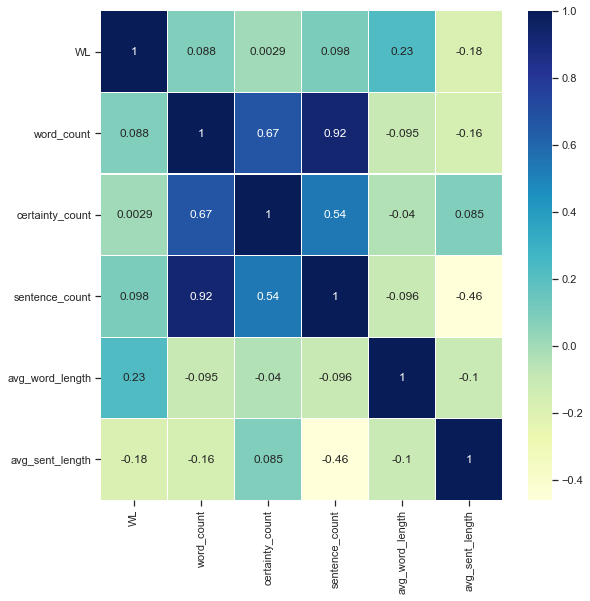

In [36]:
#creating a copy of the dataframe without the PP value for the visualisation 
cdf = df[['WL', 'word_count', 'certainty_count', 'sentence_count', 'avg_word_length', 'avg_sent_length']].copy()
corrmat = cdf.corr()
  
f, ax = plt.subplots(figsize =(9, 9))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot=True)

As per the peasron correlation, 1 is the correlation of the value with itself while 0 will be instances of no correlation. The output dataframe can be interpreted as for any cell, by examining the row variable correlation with the corresponding column variable. 
Generally a positive or negative value from 0.9 indicates a very strong correlation while data from 0 to 0.3 indicates a negligible correlation. 

In our dataframe the most significant correlation with winning or losing is with the average word length, however even that is at 0.2 which indicates its on the lower end of the correlation. With the limited dataset it appears that the impact of winning and losing is not affected by the nature of words or their length. With a larger dataset however, there may be chances of finding patterns of stronger correlation. A further variable with variable analysis can be undertaken to ascertain if there is any other correlation which is notable.


### Analysis: Length of Brief

Lets analyse the relationship between the word count and the chance of winning on appeal. This is using a seaborn box plot with with the win/loss variable on the x axis and the word count variable on the y axis with hue as the procedural posture.

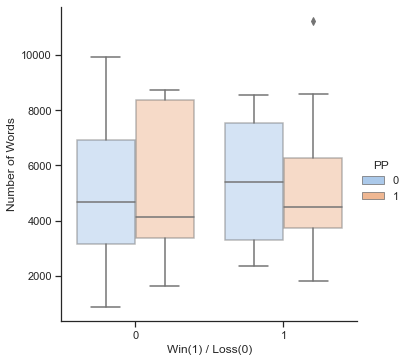

In [37]:
sns.catplot(x="WL", y="word_count", hue = 'PP', kind = 'box',   data=df, boxprops=dict(alpha=.5), palette = 'pastel')
plt.xlabel('Win(1) / Loss(0)')
plt.ylabel('Number of Words')
plt.show()

We can further calculate the average word count of the briefs of the winning vs. the losing side to see if there is a notable difference. 

In [38]:
print(df.groupby(['WL'])['word_count'].mean())

WL
0    4862.820513
1    5287.243902
Name: word_count, dtype: float64


As per the calculations above of the average word count and the box plot of the word count it appears that briefs with slightly higher word counts have a higher chance of winning, however the difference in the average of the two figures is not substantially significant. 
From the box while there isn't a clear difference between the plots, it does appear that winning briefs start with more words while the total word count does remain similar. 


There is a slightly higher chance of winning when the word count of the brief is higher. As is evident from the groupby and the barplot there isn't a major difference in the word count so with the current data set it can't be conclusively stated that the number of substantial words in a brief has a bearing on the chance of winning. 

In this data set, the box plot shows that brief submitted by the appellants have a higher even with word counts higher than the mean count. It also appears that in the losing side there is a wider spectrum ranging from less than 1000 - 10,000 words while the word count of the winning side is concentrated in the 2000 - 8000 words bracket.





Plotting the bar plot with the same parameters as above now with the average sentence length 

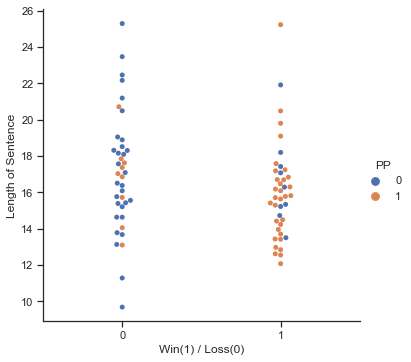

In [39]:
#plotting with disabled jitters, using swarm since this is a small dataset and can display all figures easily
sns.catplot(data=df, x='WL', y='avg_sent_length', hue = 'PP', kind = 'swarm')
plt.xlabel("Win(1) / Loss(0)")
plt.ylabel("Length of Sentence")
plt.show()

Also calculating the mean with the groupby function to see if there is a significant correlation

In [40]:
print(df.groupby(['WL'])['avg_sent_length'].mean())

WL
0    17.084008
1    15.991124
Name: avg_sent_length, dtype: float64


There is a slightly higher chance of winning when the length of the sentences is lesser. However, as was the case with the word count, there isn't a remarkable difference. The swarm plot also shows a similar result as the word count box plot. On the winning side the data is  more concentrated and briefs with smaller sentence lengths have a higher chance of winning. While the difference isn't significant, there appears to be an inverse relationship between the average length of sentences and the chances of winning. 

Plotting a histplot with the average word length and the win/ loss data

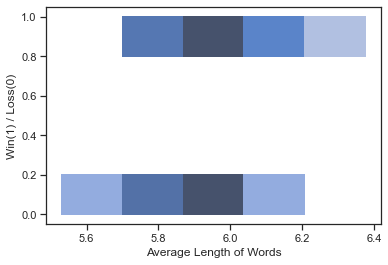

In [46]:
sns.histplot(data = df, x = 'avg_word_length', y = 'WL', multiple="dodge", shrink = 0.5, bins = 5)
plt.xlabel('Average Length of Words')
plt.ylabel('Win(1) / Loss(0)')
plt.show()

In [42]:
print(df.groupby(['WL'])['avg_word_length'].mean())

WL
0    5.874259
1    5.940529
Name: avg_word_length, dtype: float64


As per the plot above, it appears for a slightly longer word average there is a higher win rate. 

This concludes the analysis for the average length of the brief. With the current data set there isn't a significant co-relation between the average length of the brief and it been drafted by the winning or the losing side. But briefs with a lower word count and lower sentence length have won on appeal more. 

### Analysis: Vocabulary

Now to analyse if the vocabulary used has a bearing on the chances of winning. 
Plotting a violin plot to assess the relationship between the certainty count and the win/lose data.

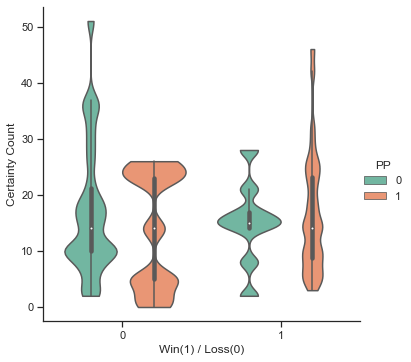

In [43]:
sns.catplot(x="WL", y="certainty_count", hue="PP", data=df, kind="violin", bw=.15, cut=0, split = False, palette="Set2")
plt.xlabel("Win(1) / Loss(0)")
plt.ylabel("Certainty Count")
plt.show()

In [44]:
print(df.groupby(['WL'])['certainty_count'].mean())

WL
0    16.256410
1    16.317073
Name: certainty_count, dtype: float64


From this plot it cannot be affirmatively stated that the usage of a specific set of words has a bearing on who wins, this might change if for case briefs in the same subject matter of law where specific words can be included for detailed analysis.


Finally, another method for specifically analysing the vocabulary is to check the frequency distribution of the words in the brief and then compare the usage of the words with other briefs, the below illustration analyses only 2 sample briefs from the dataframe. As the subject matter for the briefs isn't similar there wont be substantial results with a specific analysis of this kind but where the is an overlap in of field this analysis would be significant and helpful once scaled up for larger datasets.

In [47]:
fdist1 = FreqDist((df['vocabulary'][1]))
print("Frequency distribution for " + df['Filename'][1])
print(fdist1)
fdist2 = FreqDist((df['vocabulary'][2]))
print("Frequency distribution for " + df['Filename'][2])
print(fdist2)

Frequency distribution for brief_39a.txt
<FreqDist with 659 samples and 2749 outcomes>
Frequency distribution for brief_35b.txt
<FreqDist with 851 samples and 4290 outcomes>


In [48]:
print(fdist1.most_common(2))
print(fdist2.most_common(2))

[('state', 89), ('associ', 83)]
[('burton', 81), ('district', 62)]


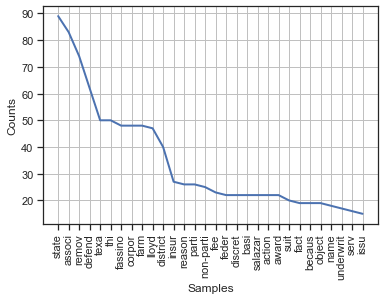

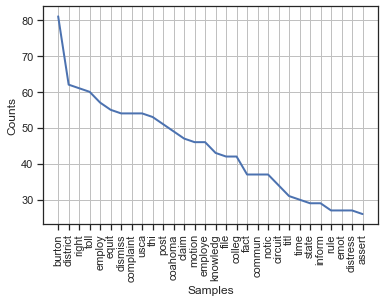

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [49]:
fdist1.plot(30,cumulative=False)
fdist2.plot(30,cumulative=False)

### Summary

There was a compressed directory of case briefs provided for analysis which was decompressed and extracted. A csv file was created to store all the briefs in one documents for analysis. Using the metadata that was part of each brief the csv file was updated with each row containing the data from the individual files. The csv file was read in as a pandas dataframe for analysis. From the dataframe, text was cleaned to remove short words and punctuation. 
Thereon the word count of the text of each brief and the average sentence length was computed. This was later analysed to determine the relationship in the provided dataset of the average length of the brief and chances of winning on appeal. 
Finally, the vocabulary analysis was conducted, for this each word in the text of the brief was reduced to its stem, then all commonly   appearing stop words and legalese in the brief were removed. The analysis conducted here was to see if the usage of the words that are more persuasive and certain or are used as legal jargon would have a bearing on the chances of winning on appeal. 
